In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk

2024-10-06 19:45:22.437429: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 19:45:22.518107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


2024-10-06 19:45:36.791803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-06 19:45:36.887853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-06 19:45:36.888150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
#preprocessed_SNL_data.h5 is located under s3df /sdf/home/h/hjia625/
with h5py.File('/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/preprocessed_SNL_data.h5', 'r') as hf:
    X_train = hf['X_train'][:]
    X_test  = hf['X_test'][:]
    Ato4l_data  = hf['Ato4l_data'][:]
    hToTauTau_data  = hf['hToTauTau_data'][:]
    hChToTauNu_data  = hf['hChToTauNu_data'][:]
    leptoquark_data = hf['leptoquark_data'][:]
    print("Data loaded from preprocessed_SNL_data.h5")


Data loaded from preprocessed_SNL_data.h5


In [5]:
# filename = "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/SM_ZeroBias_dataset.h5"
# with h5py.File(filename, 'r') as file:
#     X_train = np.array(file['X_train'])
#     X_test = np.array(file['X_test'])
#     X_val = np.array(file['X_val'])
# X_train = np.vstack((X_train, X_val))
# print(X_train.shape)

In [6]:
# def scale_columns(arr):
#     # Check if the input array has 57 columns
#     if arr.shape[1] != 57:
#         raise ValueError("Input array must have 57 columns")
    
#     # Create a copy of the input array to avoid modifying the original
#     scaled_arr = arr.copy()
# #     met_scale = 1
# #     em_scale = 1
# #     tau_scale = 1
# #     jet_scale = 1
# #     muon_scale = 1
#     met_scale = 512
#     em_scale = 128
#     tau_scale = 128
#     jet_scale = 256
#     muon_scale = 32
#     # Define the scaling factors for each column
#     scale_dict = {
#         0: 1/met_scale,
#         3: 1/em_scale, 6: 1/em_scale, 9: 1/em_scale, 12: 1/em_scale, 15: 1/tau_scale,
#         18: 1/tau_scale, 21: 1/tau_scale, 24: 1/tau_scale,
#         27: 1/jet_scale, 30: 1/jet_scale, 33: 1/jet_scale, 36: 1/jet_scale, 39: 1/jet_scale, 42: 1/jet_scale,
#         45: 1/muon_scale, 48: 1/muon_scale, 51: 1/muon_scale, 54: 1/muon_scale
#     }

#     # Apply scaling to the specified columns
#     for col, scale_factor in scale_dict.items():
#         scaled_arr[:, col] *= scale_factor
    
#     return scaled_arr
# X_train = scale_columns(X_train)
# X_test = scale_columns(X_test)

In [7]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [8]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]
        
        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()
        
        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
analyze_columns(X_train)

Column 1:
  Mean: -0.0000
  Min: -1.9571
  Max: 53.1526
  Contains NaN: False

Column 2:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 3:
  Mean: 0.0000
  Min: -1.7323
  Max: 1.7311
  Contains NaN: False

Column 4:
  Mean: -0.0000
  Min: -0.9537
  Max: 47.1318
  Contains NaN: False

Column 5:
  Mean: -0.0000
  Min: -2.4819
  Max: 2.4821
  Contains NaN: False

Column 6:
  Mean: -0.0000
  Min: -2.3496
  Max: 2.3489
  Contains NaN: False

Column 7:
  Mean: -0.0000
  Min: -0.0355
  Max: 200.8080
  Contains NaN: False

Column 8:
  Mean: -0.0000
  Min: -43.0203
  Max: 43.0213
  Contains NaN: False

Column 9:
  Mean: 0.0000
  Min: -34.6662
  Max: 34.6653
  Contains NaN: False

Column 10:
  Mean: 0.0000
  Min: -0.0108
  Max: 302.0646
  Contains NaN: False

Column 11:
  Mean: -0.0000
  Min: -181.6179
  Max: 181.7817
  Contains NaN: False

Column 12:
  Mean: -0.0000
  Min: -130.9459
  Max: 130.8367
  Contains NaN: False

Column 13:
  Mean: -0.0000
  Min: -0.0028
  Max:

In [6]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-2
    inputs = keras.Input(shape=(input_dim), name = "input")
#     x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense1")(inputs)
#     x = BatchNormalization(name="BN1")(x)
#     x = ReLU(name="relu1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense2")(x)    
#     x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-2
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
#     jet_scale = 256/64
#     tau_scale = 128/64
#     muon_scale = 32/64
#     met_scale = 512/64
#     em_scale = 128/64
    jet_scale = 1
    tau_scale = 1
    muon_scale = 1
    met_scale = 1
    em_scale = 1
    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: met_scale,
        3: em_scale, 6: em_scale, 9: em_scale, 12: em_scale,
        15: tau_scale, 18: tau_scale, 21: tau_scale, 24: tau_scale,
        27: jet_scale, 30: jet_scale, 33: jet_scale, 36: jet_scale, 39: jet_scale, 42: jet_scale,
        45: muon_scale, 48: muon_scale, 51: muon_scale, 54: muon_scale
    }

    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)

    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor

    # Hardcoded lists for eta and phi indices
    eta_indices = [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
    phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56]

    batch_size = tf.shape(scaled_reconstruction)[0]
    
    # Set only the first eta (index 1) to zero
    indices = tf.stack([tf.range(batch_size), tf.ones(batch_size, dtype=tf.int32)], axis=1)
    updates = tf.zeros(batch_size)
    scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
#     # Apply constraints to eta
#     for i in eta_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
#     # Apply constraints to phi
#     for i in phi_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3.14159265258979 * tf.tanh(scaled_reconstruction[:, i] / 3.14159265258979)
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
        
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)

    # Take the sum across all dimensions
    return tf.reduce_sum(mse)

class VAE_Model(keras.Model):
    def __init__(self, encoder, decoder, steps_per_epoch=3125, cycle_length=10, min_beta=0.1, max_beta=0.85, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)
#     def set_beta(self,beta):
#         self.beta=beta

    def train_step(self, data):
        # Get the current epoch number
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mask = K.cast(K.not_equal(data, 0), K.floatx())
#             reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)
#         reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "beta": self.beta,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        } 

In [10]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [11]:
NUM_EPOCHS = 100
BATCH_SIZE = 1024
STOP_PATIENCE = 10
LR_PATIENCE = 5

In [12]:
#TOPO 2A Trainer

T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],64,32,6)
T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],64,32,6)
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8)
opt = keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5, clipnorm=1.0)
T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]
# T2A.build(input_shape=(997315, 110))
T2A_enc.summary()
T2A_dec.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 57)]                 0         []                            
                                                                                                  
 dense1 (Dense)              (None, 64)                   3712      ['input_1[0][0]']             
                                                                                                  
 relu1 (ReLU)                (None, 64)                   0         ['dense1[0][0]']              
                                                                                                  
 dense2 (Dense)              (None, 32)                   2080      ['relu1[0][0]']               
                                                                                            

In [13]:
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

tf.keras.backend.clear_session()
history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
T2A.save_weights(filepath='/eos/user/h/hjia/ToyVAE/software_dev/software_model/checkpoint_64_32_6/', save_format='tf')

Epoch 1/100
2500/2500 [==============================] - 13s 5ms/step - loss: 759.0730 - reco_loss: 758.4963 - kl_loss: 0.8692 - beta: 0.1570 - val_loss: 697.3503 - val_reco_loss: 696.1163 - val_kl_loss: 1.2341 - val_beta: 0.1570 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 10s 4ms/step - loss: 408.5591 - reco_loss: 407.2187 - kl_loss: 1.4620 - beta: 0.2130 - val_loss: 589.8976 - val_reco_loss: 588.2587 - val_kl_loss: 1.6389 - val_beta: 0.2130 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 11s 4ms/step - loss: 1424.3326 - reco_loss: 1298.8546 - kl_loss: 150.3042 - beta: 0.2690 - val_loss: 566.1252 - val_reco_loss: 564.0715 - val_kl_loss: 2.0537 - val_beta: 0.2690 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 11s 5ms/step - loss: 344.2599 - reco_loss: 341.9082 - kl_loss: 2.4324 - beta: 0.3250 - val_loss: 493.8474 - val_reco_loss: 491.4747 - val_kl_loss: 2.3726 - val_beta: 0.3250 - lr: 0.0010
Epoch 5/100
2500/2500 [=

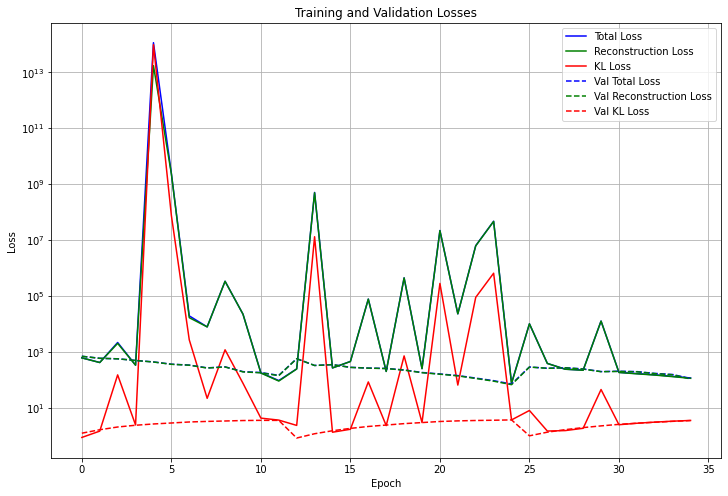

In [14]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by your model.fit() call

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# # Repeat testing
# for i in range(0,20):
#     T2A_enc = Qmake_encoder_set_weights(X_train.shape[1],64,32,6)
#     T2A_dec = Qmake_decoder_set_weights(X_train.shape[1],64,32,6)
#     steps_per_epoch = X_train.shape[0] // BATCH_SIZE
#     T2A = VAE_Model(T2A_enc, T2A_dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.7)
#     # T2A.set_beta(beta)
#     opt = keras.optimizers.Adam(learning_rate=0.001)
#     T2A.compile(optimizer=opt,weighted_metrics=[weighted_mse]) #,weighted_metrics=[weighted_mse]

#     early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

#     callbacks = [early_stopping, reduce_lr]

#     tf.keras.backend.clear_session()
#     history = T2A.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
#     T2A.save_weights(filepath='/eos/user/h/hjia/ToyVAE/software_dev/software_model/checkpoint_small/Repeat_Testing/small_{}/'.format(i), save_format='tf')

In [15]:
# signals_file = ["/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/Ato4l_dataset.h5",
#                 "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/hToTauTau_dataset.h5",
#                 "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/hChToTauNu_dataset.h5",
#                 "/eos/user/h/hjia/AnomalyDetection/liam_AD/training_notebooks/leptoquark_dataset.h5"]
signal_labels = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"]

In [16]:
signal_data = [Ato4l_data,
               hToTauTau_data,
               hChToTauNu_data,
               leptoquark_data]
# for i, label in enumerate(signal_labels):
#     with h5py.File(signals_file[i], 'r') as file:
#         test_data = np.array(scaler.transform(file['Data']))
# #         test_data = scale_columns(np.array(file['Data']))
#         signal_data.append(test_data)

In [17]:
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_CKL(z_mean, z_log_var):
    CKL = np.mean(z_mean**2)
    return CKL

class Model_Evaluator:
    def __init__(
        self,
        model_path,
        background,
        br_weights,
        signal,
        signal_weights,
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
    ):

        self.input_dim = input_dim
        vae_enc = Qmake_encoder_set_weights(input_dim, 64,32,6)
        vae_dec = Qmake_decoder_set_weights(input_dim, 64,32,6)
        self.model = VAE_Model(vae_enc, vae_dec)
        self.model.load_weights(model_path)
        self.encoder = self.model.get_layer("encoder")
        self.signal = signal
        self.background = background
        self.br_loss = []
        self.signal_loss = []
        self.background_outputs = []
        self.signal_outputs = []
        self.title = title
        self.saveplots = save
        self.labels = labels
        self.latent_info = []
        self.br_weights = br_weights
        self.signal_weights = signal_weights

    def calculate_loss(self, l_type):
        self.signal_loss = []
        self.br_loss = []
        br = self.background

        if l_type == "CKL":
            br_latent = np.array(self.encoder.predict(br))
            self.latent_info += [br_latent[0]]
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_CKL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))
                self.latent_info += [sg_latent[0]]
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_CKL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "KL":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_KL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_KL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]        

    def ROC(self):
        target_fpr = 1e-5
        tpr_at_target = []
        thresholds_at_target = []

        plt.plot(
            np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
        )
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr, label=self.labels[j] + ": " + str(round(auc, 3)))
            
            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])


        plt.xlabel("fpr")
        plt.xlim(1e-7, 1)
        plt.ylim(1e-7, 1)
        plt.semilogx()
        plt.ylabel("tpr")
        plt.semilogy()
        plt.title("{}_ROC".format(self.title))
        plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots == True:
            plt.savefig(
                "/eos/user/h/hjia/ToyVAE/software_dev/plots/small/{}_ROC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()
        
        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        for label, tpr, threshold in zip(self.labels, tpr_at_target, thresholds_at_target):
            print(f"{label}: {tpr*100:.6f}%, Theshold = {threshold:.6f}")

    def GetPerformance(self):
        target_fpr = 1e-5
        tpr_at_target = []

        print(f"Number of signal losses: {len(self.signal_loss)}")
        print(f"Number of labels: {len(self.labels)}")
        print(f"Number of signal weights: {len(self.signal_weights)}")
        print(f"Length of br_loss: {len(self.br_loss)}")

        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal")

        for j, batch in enumerate(self.signal_loss):
            print(f"Processing batch {j}")
            print(f"Batch length: {len(batch)}")
            print(f"Signal weight length: {len(self.signal_weights[j])}")

            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = np.concatenate([np.zeros(len(self.br_loss)), np.ones(len(batch))])
            ROC_data = np.concatenate((self.br_loss, batch))

            print(f"ROC_data shape: {ROC_data.shape}")
            print(f"truth shape: {truth.shape}")
            print(f"weights shape: {weights.shape}")

            try:
                fpr, tpr, _ = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                auc = sk.roc_auc_score(truth, ROC_data)

                plt.plot(fpr, tpr, label=f"{self.labels[j]}: {auc:.3f}")

                idx = np.argmin(np.abs(fpr - target_fpr))
                tpr_at_target.append(tpr[idx])

                print(f"Successfully processed batch {j}")
            except Exception as e:
                print(f"Error processing batch {j}: {str(e)}")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f"{self.title} ROC")
        plt.vlines(target_fpr, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots:
            plt.savefig(
                f"/eos/user/h/hjia/ToyVAE/software_dev/plots/small/{self.title}_ROC.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        results = list(zip(self.labels, tpr_at_target))
        for label, tpr in results:
            print(f"{label}: {tpr*100:.6f}%")

        print(f"Number of results: {len(results)}")
        return results


10642/10642 [==============================] - 10s 962us/step


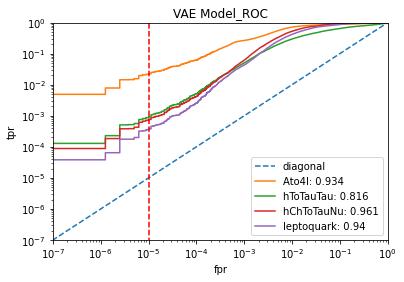


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.149404%, Theshold = 10665.125977
hToTauTau: 0.087084%, Theshold = 10665.125977
hChToTauNu: 0.071422%, Theshold = 10665.125977
leptoquark: 0.035531%, Theshold = 10665.125977


In [19]:
Losses=['CKL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/ToyVAE/software_dev/software_model/checkpoint_64_32_16/',
                               X_test,
                               np.ones(len(X_test)),
                               signal_data,
                               [np.ones(len(Ato4l_data)),
                                    np.ones(len(hToTauTau_data)),
                                    np.ones(len(hChToTauNu_data)),
                                    np.ones(len(leptoquark_data))],
                               input_dim = X_test.shape[1],
                               title='VAE Model',
                               save = False,
                               labels = signal_labels)
    evaluation.calculate_loss(string)
    evaluation.ROC()

In [ ]:
# results = []
# signal_names = ["Ato4l",
#                 "hToTauTau",
#                 "hChToTauNu",
#                 "leptoquark"]
# channel_results = {}
# for i in range(20):
#     try:
#         model_path = f'//eos/user/h/hjia/ToyVAE/software_dev/software_model/checkpoint_small/Repeat_Testing/small_{i}/'
#         print(f"Evaluating model from path: {model_path}")
#         evaluation = Model_Evaluator(model_path,
#                                X_test,
#                                np.ones(len(X_test)),
#                                signal_data,
#                                [np.ones(len(Ato4l_data)),
#                                     np.ones(len(hToTauTau_data)),
#                                     np.ones(len(hChToTauNu_data)),
#                                     np.ones(len(leptoquark_data))],
#                                input_dim = X_test.shape[1],
#                                title='VAE Model {i}',
#                                save = False,
#                                labels = signal_labels)
        
#         print("Model_Evaluator instance created successfully")
        
#         print("Calculating losses...")
#         evaluation.calculate_loss('KL')
#         print("Losses calculated")
        
#         print("Getting performance...")
#         result = evaluation.GetPerformance()
#         print(f"GetPerformance() returned: {result}")
        
#         if not result:
#             print(f"Warning: GetPerformance() returned an empty result for model {i}")
#         else:
#             for channel, tpr in result:
#                 if channel not in channel_results:
#                     channel_results[channel] = []
#                 channel_results[channel].append(tpr)
    
#     except Exception as e:
#         print(f"An error occurred while evaluating model {i}:")
#         print(traceback.format_exc())

# print("Final channel results:", channel_results)

In [ ]:
# if channel_results:
#     plt.figure(figsize=(12, 6))
#     channels = list(channel_results.keys())
#     n_channels = len(channels)
#     n_models = len(channel_results[channels[0]])
    
#     x = np.arange(n_models)
#     width = 0.8 / n_channels
    
#     for i, channel in enumerate(channels):
#         tprs = channel_results[channel]
#         plt.bar(x + i * width, tprs, width, label=channel)
    
#     plt.xlabel('Models')
#     plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
#     plt.title('TPR Comparison Across Models and Channels')
#     plt.xticks(x + width * (n_channels - 1) / 2, [f'Model {i}' for i in range(n_models)])
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
#     plt.show()
    
#     # Print statistics
#     print("\nChannel Statistics:")
#     for channel in channels:
#         tprs = channel_results[channel]
#         mean = np.mean(tprs)
#         std = np.std(tprs)
#         print(f"{channel}: Mean TPR = {mean*100:.4f}%, Std Dev = {std:.4f}")
# else:
#     print("No results were obtained. Cannot create comparison plot.")

In [ ]:
# if channel_results:
#     plt.figure(figsize=(14, 8))  # Increased figure size to accommodate the legend
#     channels = list(channel_results.keys())
#     n_channels = len(channels)
#     n_models = len(channel_results[channels[0]])
    
#     for i, channel in enumerate(channels):
#         tprs = channel_results[channel]
#         plt.scatter(range(n_models), tprs, label=channel, s=50)
    
#     plt.xlabel('Models')
#     plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
#     plt.semilogy()
#     plt.title('TPR Comparison Across Models and Channels')
#     plt.xticks(range(n_models), [f'{i}' for i in range(n_models)])
#     plt.grid(True, linestyle='--', alpha=0.7)
    
#     # Place legend outside the plot
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
#     plt.tight_layout()
#     plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
#     plt.show()
    
#     # Print statistics
#     print("\nChannel Statistics:")
#     for channel in channels:
#         tprs = channel_results[channel]
#         mean = np.mean(tprs)
#         std = np.std(tprs)
#         print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
# else:
#     print("No results were obtained. Cannot create comparison plot.")

In [10]:
ori_vae_enc = Qmake_encoder_set_weights(57,64,32,6)
ori_vae_dec = Qmake_decoder_set_weights(57,64,32,6)
orginal_model = VAE_Model(ori_vae_enc, ori_vae_dec)
# orginal_model.predict(Ato4l_data)
orginal_model.load_weights("/eos/user/h/hjia/ToyVAE/software_dev/software_model/checkpoint_64_32_16/")


def make_simplified_encoder(input_dim, h_dim_1, h_dim_2, latent_dim):
    inputs = keras.Input(shape=(input_dim,), name='inputs')
#     x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             name = "dense1")(inputs)
#     x = BatchNormalization(name="BN1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             name = "dense2")(x)    
#     x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros())(x)
    new_encoder = keras.Model(inputs,z_mean,name='encoder')
    return new_encoder

In [11]:
new_encoder = make_simplified_encoder(57,64,32,6)
# Transfer weights from the original encoder
for layer in new_encoder.layers:
    if layer.name == "inputs":
        continue
    original_layer = ori_vae_enc.get_layer(layer.name)
    if original_layer is not None:
        print("set weight for ", layer)
        print(original_layer.get_weights())
        layer.set_weights(original_layer.get_weights())

set weight for  <keras.src.layers.core.dense.Dense object at 0x7f3c40462310>
[array([[-0.01120105,  0.16174847, -0.00167761, ..., -0.05897411,
         0.01546789, -0.00332473],
       [ 0.09092497,  0.06631313, -0.15556325, ...,  0.02905586,
        -0.29567984, -0.2209253 ],
       [-0.2697083 , -0.0015518 , -0.00500748, ...,  0.00659142,
         0.0339653 ,  0.03987942],
       ...,
       [-0.1026824 , -0.44247344, -0.05702486, ..., -0.6344656 ,
         0.0938441 , -0.39519337],
       [-0.06126444,  0.12735067, -0.14027563, ...,  0.22914706,
         0.07936793,  0.01225108],
       [-0.00343627, -0.20568126, -0.15884653, ..., -0.43450087,
         0.11746287,  0.04422086]], dtype=float32), array([ 4.89027441e-01,  1.04924750e+00, -1.16830885e-01,  7.24407315e-01,
        4.12179530e-01, -1.00151807e-01,  1.06026106e-01, -6.40499145e-02,
       -1.46371067e-01, -3.89879830e-02, -2.76465237e-01,  2.21332073e-01,
        4.31533270e-02, -1.82791576e-02, -8.85990977e-01,  3.9117294

In [12]:
tf.keras.models.save_model(new_encoder, 'VAE_40MHZ_model_64_32_6_onchip', save_format='tf')

INFO:tensorflow:Assets written to: VAE_40MHZ_model_64_32_6_onchip/assets


INFO:tensorflow:Assets written to: VAE_40MHZ_model_64_32_6_onchip/assets
